# Forward prediction of Hindi sentiment(s) in CrowdTangle dataset

## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 15.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.2/431.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 17.8 MB/s eta 0:00:00
  Attempting unins

In [54]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

## Load the `CrowdTangle` dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv (
    '/content/drive/My Drive/The-London-Story/CrowdTangle-TLS-workspace/2022-07-11-16-34-58-CEST-Historical-Report-2016-12-31--2022-07-11.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=';', 
    error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df.shape

(604703, 40)

Because the size of the dataset is too large, let's choose first N values from the dataframe

In [7]:
df = df.head(500)

In [8]:
df.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

## Data preprocessing

Replace NaN values in particular columns with empty string

In [9]:
df.message = df.message.fillna('')
df.description = df.description.fillna('')
df.imageText = df.imageText.fillna('')

Extract particular columns and convert into lists

In [10]:
message_list = df ['message'].tolist()
imageText_list = df ['imageText'].tolist()

print ("Total number of entries in the dataset:", len(message_list))

Total number of entries in the dataset: 500


## Load the sentiment analysis model and the tokenizer


Define parameters

In [11]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 32

n_labels = 3

labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

max_length = 312

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

Load the model and the tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

config = AutoConfig.from_pretrained(MODEL) # used for id to label name (optional)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Define the forward prediction functions

In [25]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [29]:
def sentiment_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  sentiment_pred = []

  for idx, batch in enumerate(dl):
    print('Batch ',idx+1,' of ', len(dl))

    if (batch != ''):
      scores = forward(batch, cuda=CUDA)
      preds = np.argmax(scores, axis=-1)
    else:
      preds = 1
    sentiment_pred.extend(preds)
  
  return sentiment_pred

## Run sentiment prediction task on the dataset(s) and save the results

In [30]:
message_sentiment_score = sentiment_pred_score (message_list)

Batch  1  of  16
Batch  2  of  16
Batch  3  of  16
Batch  4  of  16
Batch  5  of  16
Batch  6  of  16
Batch  7  of  16
Batch  8  of  16
Batch  9  of  16
Batch  10  of  16
Batch  11  of  16
Batch  12  of  16
Batch  13  of  16
Batch  14  of  16
Batch  15  of  16
Batch  16  of  16


In [59]:
imageText_sentiment_score = sentiment_pred_score (imageText_list)

Batch  1  of  16
Batch  2  of  16
Batch  3  of  16
Batch  4  of  16
Batch  5  of  16
Batch  6  of  16
Batch  7  of  16
Batch  8  of  16
Batch  9  of  16
Batch  10  of  16
Batch  11  of  16
Batch  12  of  16
Batch  13  of  16
Batch  14  of  16
Batch  15  of  16
Batch  16  of  16


Append the prediction scores to the original pandas dataframe

In [60]:
df ['messageSentiment.score'] = message_sentiment_score
df ['imageTextSentiment.score'] = imageText_sentiment_score

In [61]:
df.head()

,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,expandedLinks.expanded,imageText,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,messageSentiment.score,imageTextSentiment.score
0,Bajrangi Dal,BajrangDalKolkata,354861651263021,RELIGIOUS_ORGANIZATION,IN,अपने और अपनोँ के सुरक्षित भविष्य हेतु बँगाली ...,2012-09-12 10:38:05,35222.0,41363.0,2022-07-11 13:08:35 CEST,...,NaN,,NaN,,NaN,NaN,NaN,-2.82,1,0
1,True Nationalist,TrueNationalistOfficial,623564924746688,LOCAL,IN,हिन्दू धर्म से संबंधित वीडियो के लिए हमारे पेज...,2019-03-09 08:12:47,275031.0,555551.0,2022-07-11 12:41:07 CEST,...,NaN,,अनिल कपूर गुंजी बच्चे की किलकारियां बन गए नाना...,बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...,NaN,NaN,NaN,-0.64,2,0
2,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,445145.0,848530.0,2022-07-11 12:38:52 CEST,...,NaN,,अनिल कपूर गुंजी बच्चे की किलकारियां बन गए नाना...,बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...,NaN,NaN,NaN,1.37,2,0
3,True Nationalist,TrueNationalistOfficial,623564924746688,LOCAL,IN,हिन्दू धर्म से संबंधित वीडियो के लिए हमारे पेज...,2019-03-09 08:12:47,275063.0,555595.0,2022-07-11 12:09:08 CEST,...,NaN,,पट्रोल-डीजल को लेकर आई खुशखबरी मिल रहा है मात्...,पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...,NaN,NaN,NaN,-0.71,2,0
4,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,445145.0,848530.0,2022-07-11 12:06:36 CEST,...,NaN,,पट्रोल-डीजल को लेकर आई खुशखबरी मिल रहा है मात्...,पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...,NaN,NaN,NaN,1.53,2,0


Save the dataframe (along with the results)

In [65]:
df.to_csv('/content/drive/MyDrive/CT_sentiment_prediction.csv', index=False)

## Visualization of the results

Histograms of the predicted scores

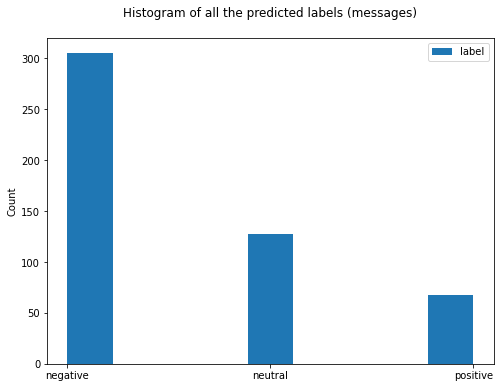

In [62]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots (figsize=(8, 6))
plt.title ('Histogram of all the predicted labels (messages)\n')
plt.hist (df ['messageSentiment.score'], bins, label=['label'] )
ax.set_ylabel ('Count')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.legend (loc='upper right')
plt.show ()

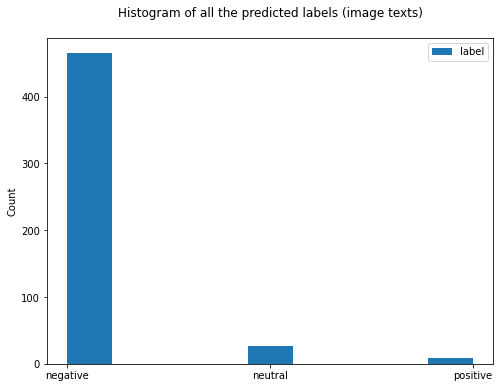

In [63]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots (figsize=(8, 6))
plt.title ('Histogram of all the predicted labels (image texts)\n')
plt.hist (df ['imageTextSentiment.score'], bins, label=['label'] )
ax.set_ylabel ('Count')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.legend (loc='upper right')
plt.show ()

Bar plot of top actors

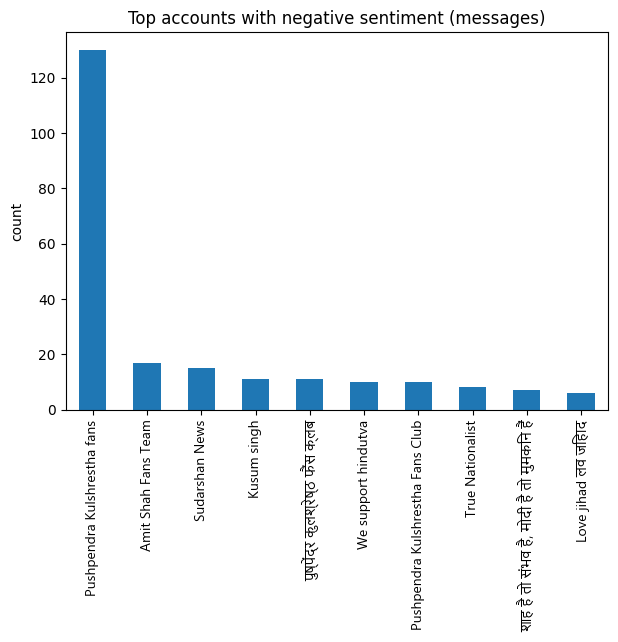

In [66]:
plt.figure(figsize=(7,5),dpi=100)

negative_sentiment = df [df['messageSentiment.score'] == 0]
negative_sentiment ['account.name'].value_counts()[:10].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/The-London-Story/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)

plt.title('Top accounts with negative sentiment (messages)')
plt.ylabel('count')

plt.show()

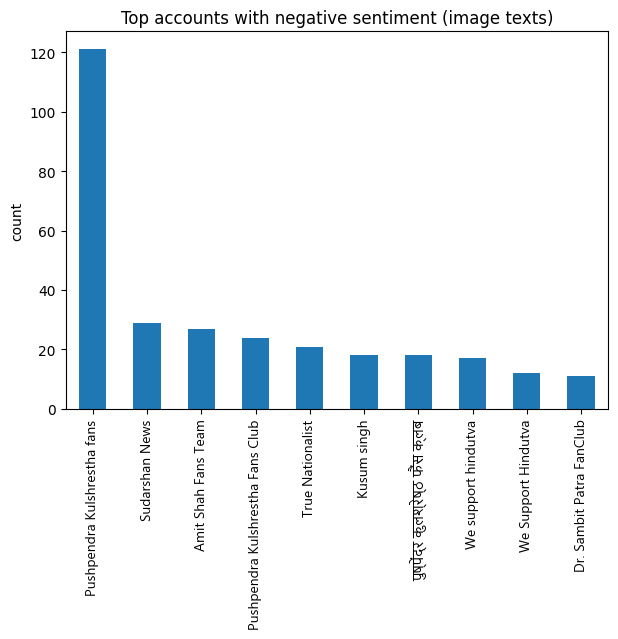

In [64]:
plt.figure(figsize=(7,5),dpi=100)

negative_sentiment = df [df['imageTextSentiment.score'] == 0]
negative_sentiment ['account.name'].value_counts()[:10].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/The-London-Story/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)

plt.title('Top accounts with negative sentiment (image texts)')
plt.ylabel('count')

plt.show()